## PTSD & Suicidality/Suicidal Ideation Use Case
## Proposed Walkthrough/"Solution"
#### Written: 10/12/2020
#### Updated: 11/10/2020

### Introduction
The below document includes code and descriptive text evaluating the use case assessment *title here*. Full materials for this use case can be found on the [Python OER GitHub Repository](https://github.com/domdisanto/Python_OER/tree/master/Use%20Cases/PTSD%20%26%20SRB%20Use%20Case). This walkthrough document is tentatively titled a "solution" as, while this document offers a specific way of cleaning and analyzing the available, this document certainly does not offer a unique (or even a uniquely-best) solution to the given assessment. 

The writing in this document will do its best to outline specific parameters that should be met to satisfactorically complete the assessment. These parameters, tasks, outputs, etc. exist solely to assess your developing skills as an analyst and Python programmer. That being said, if you take different steps or follow a different analytic method to reach the same results, that is perfectly acceptable! This walk through is intended only to be *a* demonstrated workflow, but it is possible (and even likely) that you may write more efficient, simpler, or more scalable code than what is included here that achieves the same results! 

### (0) Importing modules to be used

In [1]:
# Importing some of our modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

### (1) Identify research cohort

We will first import the data, then we can very succinctly identify our research cohort of interest using `str.contains` for the ICDCodes of interest  

In [2]:
icd_cohort = pd.read_csv("PossiblePatients_ICD.csv", index_col=0)
icd_cohort.head()

,PatientID,ICDCode,Age
0,1,S82264S,31
1,1,P9681,31
2,1,S52261S,31
3,1,S72366S,31
4,1,W99XXXA,31


We will use the `str.contains` operator to examine ICD codes of interest. We are also only interested in adult patients, so we will subset to our age range of interest 

In [3]:
str_cont_subset = icd_cohort[(icd_cohort['ICDCode'].str.contains('309.81|F43.10|F43.11|F43.12')) & 
              (icd_cohort['Age']>=18)]

str_cont_subset.head()

,PatientID,ICDCode,Age
35,4,309.81,18
79,9,F43.10,28
82,10,309.81,32
90,11,F43.12,49
120,15,309.81,57


We could explicitly list all of the conditions, however see this this code is less succinct, and requires some careful bracketing of our logical statements (thus more likely to result in user error in syntax). Both subsets yield the same results:

In [4]:
ptsd_diags = ['309.81', 'F43.10', 'F43.11', 'F43.12']

logical_subset = icd_cohort[((icd_cohort['ICDCode']=='309.81') |
            (icd_cohort['ICDCode']=='F43.10') |
            (icd_cohort['ICDCode']=='F43.11') |
            (icd_cohort['ICDCode']=='F43.12')) * icd_cohort['Age']>18]

logical_subset.head()

,PatientID,ICDCode,Age
79,9,F43.10,28
82,10,309.81,32
90,11,F43.12,49
120,15,309.81,57
123,15,309.81,57


In [6]:
# and to simply get the nubmer of patients:
print('Of the', icd_cohort.shape[0], 'patients in our research extract, we identify',
     str_cont_subset.shape[0], 'adult patients with an eligible PTSD diagnosis.')

Of the 10000 patients in our research extract, we identify 514 adult patients with an eligible PTSD diagnosis.


## Research Cohort Analysis
### (1) Identifying how many patients were recruited

In [7]:
# Importing the research cohort
cohort = pd.read_csv('PTSD_ResearchCohort.csv', index_col=0)
cohort.head()

,UID,PTSD_Q1_6mo,PTSD_Q2_6mo,PTSD_Q3_6mo,PTSD_Q4_6mo,PTSD_Q5_6mo,PTSD_Q6_6mo,PTSD_Q7_6mo,PTSD_Q8_6mo,PTSD_Q9_6mo,...,PTSD_Q19_6mo,PTSD_Q20_6mo,PHQ_Q9_6mo,Age,TimeFirstDiagnosis_Months,AlcAbuse,BeckAnxiety_BL,IncomeCat,SocialSupport,PTSD_Rx
0,U200,1,0,0,0,0,1,0,1,0,...,0,0,0.0,29.0,18.0,0.0,24.0,<125% FPL,49.0,clonazepam
1,U398,0,1,2,2,0,1,0,3,0,...,0,2,0.0,45.0,17.0,1.0,0.0,400%+ FPL,59.0,clonazepam
2,Z812,2,1,1,2,0,1,1,0,0,...,0,4,0.0,39.0,18.0,0.0,21.0,125%-200% FPL,47.0,clonazepam
3,U221,0,0,0,0,1,1,2,1,3,...,3,0,0.0,54.0,24.0,0.0,0.0,<125% FPL,48.0,sertraline
4,U338,2,1,0,1,1,0,0,0,0,...,1,0,2.0,20.0,16.0,1.0,2.0,200%-400% FPL,19.0,nefazodone


In [8]:
print('Compared to the', str_cont_subset.shape[0], 'patients we identified in our ICD extract,',
     'only', cohort.shape[0],
      'patients are contained with follow-up data in our research cohort data set.')

Compared to the 514 patients we identified in our ICD extract, only 401 patients are contained with follow-up data in our research cohort data set.


### (2) Create the PTSD Outcome Variable

***Using the PTSD questionnaire vairiables, crate a binary PTSD diagnosis/outcome variable. The following links include useful resources the PTSD checklist and respective variable coding and a guide to the scoring and diagnosis of PTSD using this checklist, with relevant information included below in Figures 1A and 1B***
  
<br>  </br>

The included reference for the PTSD data included in our research data set includes the following desription to bse used for diagnosis of PTSD:

> *"A provisional PTSD diagnosis can be made by treating each item rated as 2 = "Moderately" or higher as a symptom endorsed, then following the DSM-5 diagnostic rule which requires at least: 1 B item (questions 1-5), 1 C item (questions 6-7), 2 D items (questions 8-14), 2 E items (questions 15-20)."*

So for our 20 PTSD questions, for a patient to be meet our diagnostic criteria for PTSD, they must endorse a symptom (that is report a score of 2 or greater) 

To use these criteria, we could set conditional arguments in a long if statement, but this would tediously require us to work through all 20 PTSD questions and carefully set up our conditionals:

For example:  
`IF  (ptsd_q1>=2 OR ptsd_q1>=2 OR ... OR ptsd_q5>=2) AND   
    (ptsd_q6>=2 OR ptsd_q7>=2) AND  
    (ptsd_q8>=2 OR ... OR ptsd_q14>=2) AND   
    (ptsd_q15>=2 OR ... OR ptsd_q20>=2)`
    
Rather than look at each question individually, we could identify the maximum self-reported symptom within each of these groups of questions. Then, if the maximum symptom is 2 or greater, the patient meets the criteria for a PTSD diagnosis. This code can be succinctly written as:

In [9]:
#### Generating PTSD Variable (code also included in walkthrough
for i in range(0, cohort.shape[0]):
    if min(max(cohort.iloc[i, 1:6]), max(cohort.iloc[i, 6:8]), 
           max(cohort.iloc[i, 8:15]), max(cohort.iloc[i, 15:21]))>=2:
        cohort.loc[i, 'PTSD_6mo'] = 1
    else:
        cohort.loc[i, 'PTSD_6mo'] = 0

In [10]:
cohort['PTSD_6mo'].value_counts()

0.0    258
1.0    143
Name: PTSD_6mo, dtype: int64

### (3) Create our suicidal related behavior (SRB) variable
As mentioned in the student assessment prompt, we can use the available PHQ-9 variable (related to Question 9 of the questionnaire) to categorize presence of SRB. Individuals who report a symptom (>=1) will be categorized as "present" and otherwise "absent" for our SRB outcome variable. 

In [11]:
cohort['SRB_6mo'] = np.where(cohort['PHQ_Q9_6mo']==0, 0, 1)

cohort['SRB_6mo'].value_counts()

0    238
1    163
Name: SRB_6mo, dtype: int64

In [12]:
cohort[['PTSD_6mo', 'SRB_6mo']].groupby(['PTSD_6mo', 'SRB_6mo']).size()

PTSD_6mo  SRB_6mo
0.0       0          174
          1           84
1.0       0           64
          1           79
dtype: int64

### (4) Exploratory Data Analysis and Covariate Cleaning 

We can reference our data dictionary to find our available covariates include age, time since earliest PTSD diagnosis, presence of alcohol abuse, a measure of anxiety (using the Beck Anxiety Inventory), a nominal-categorical value for income, a continuous self-reported assessment of social support, and lastly an indicator of the PTSD treatment medication prescribed over the study duration.   
  
We could also examine the columns in our data frame to see what elements are present and the pecific names of the column containing this information:

In [13]:
# Printing all columns
cohort.columns

Index(['UID', 'PTSD_Q1_6mo', 'PTSD_Q2_6mo', 'PTSD_Q3_6mo', 'PTSD_Q4_6mo',
       'PTSD_Q5_6mo', 'PTSD_Q6_6mo', 'PTSD_Q7_6mo', 'PTSD_Q8_6mo',
       'PTSD_Q9_6mo', 'PTSD_Q10_6mo', 'PTSD_Q11_6mo', 'PTSD_Q12_6mo',
       'PTSD_Q13_6mo', 'PTSD_Q14_6mo', 'PTSD_Q15_6mo', 'PTSD_Q16_6mo',
       'PTSD_Q17_6mo', 'PTSD_Q18_6mo', 'PTSD_Q19_6mo', 'PTSD_Q20_6mo',
       'PHQ_Q9_6mo', 'Age', 'TimeFirstDiagnosis_Months', 'AlcAbuse',
       'BeckAnxiety_BL', 'IncomeCat', 'SocialSupport', 'PTSD_Rx', 'PTSD_6mo',
       'SRB_6mo'],
      dtype='object')

In [14]:
# Removing the questionnaire columns for a smaller list to review
    # using the tilde (~) operator to negate the logical from str.contains
cohort.columns[~cohort.columns.str.contains('PTSD_Q|PHQ|SRB')]

Index(['UID', 'Age', 'TimeFirstDiagnosis_Months', 'AlcAbuse', 'BeckAnxiety_BL',
       'IncomeCat', 'SocialSupport', 'PTSD_Rx', 'PTSD_6mo'],
      dtype='object')

### Continuous Variables
Let's begin by simply plotting our continuous variables for some EDA. We will not worry about transforming these variables and will include them "as-is" in our models, but should examine the distributions, check for missing codes, and/or look for outliers.

#### Age

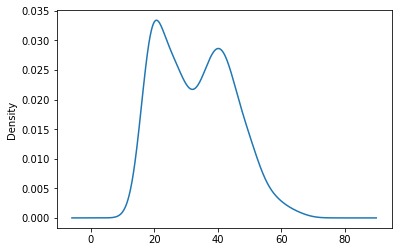

In [17]:
(cohort['Age']).plot.density()
plt.show()

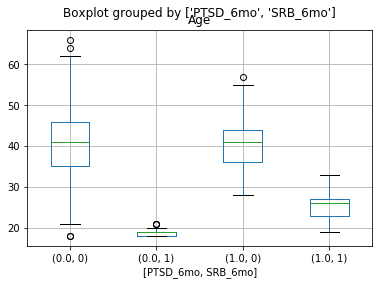

In [18]:
cohort.boxplot(column='Age', by=['PTSD_6mo', 'SRB_6mo'])
plt.show()

#### Social Support

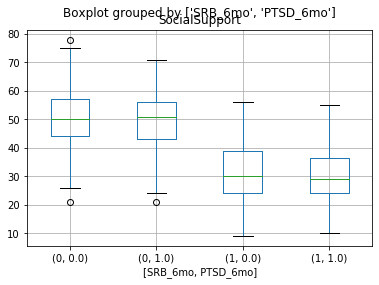

In [19]:
cohort.boxplot(column='SocialSupport', by=['SRB_6mo', 'PTSD_6mo'])
plt.show()

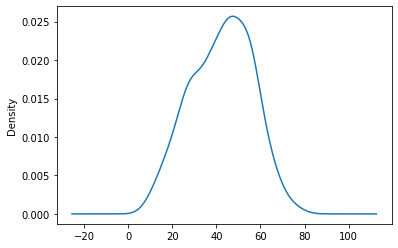

In [20]:
cohort['SocialSupport'].plot.density()
plt.show()

#### Time to Diagnosis

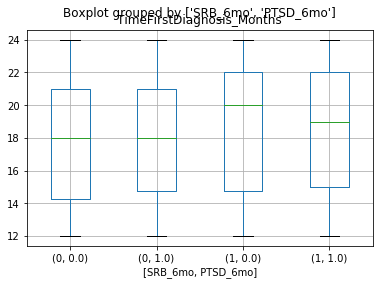

In [21]:
cohort.boxplot(column='TimeFirstDiagnosis_Months', by=['SRB_6mo', 'PTSD_6mo'])
plt.show()

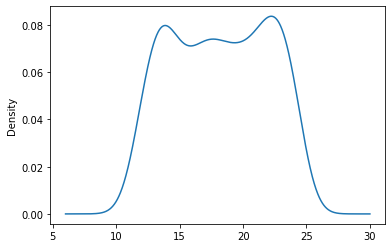

In [22]:
cohort['TimeFirstDiagnosis_Months'].plot.density()
plt.show()

#### Beck Anxiety Inventory

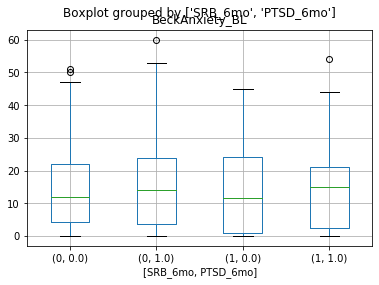

In [23]:
cohort.boxplot(column='BeckAnxiety_BL', by=['SRB_6mo', 'PTSD_6mo'])
plt.show()

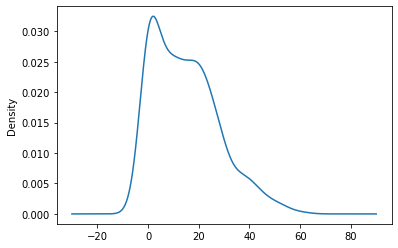

In [24]:
cohort['BeckAnxiety_BL'].plot.density()
plt.show()

### Categorical Variables
For the categorical variables, we will examine the categories present, and in variables with more than 2 distinct categories, we will create dummy variables for all categories. For those with only 1 category (i.e. binary variables), we will simply leave the variable with its given "0/1" coding. 

For this dummy variable coding, we will use `pd.get_dummies` (although `sklearn`'s `OneHotEncoder` can also be used with the same results). For each variable, I will subset only the variable and the identifier column. I will then include but not execute code that merges in these created dummy variables in to the original data frame. IN our final chunk, I will alter our data frame with a single `pd.get_dummies` call, supplying a list of the columns which will need to be dummy coded.

In [25]:
cohort['AlcAbuse'].value_counts()

0.0    234
1.0    167
Name: AlcAbuse, dtype: int64

In [26]:
cohort['IncomeCat'].value_counts()

400%+ FPL        117
<125% FPL        106
125%-200% FPL    105
200%-400% FPL     73
Name: IncomeCat, dtype: int64

In [27]:
IncomeCatDummies = pd.get_dummies(cohort[['UID', 'IncomeCat']], columns=['IncomeCat'])
IncomeCatDummies.head()
# # We can check that this works by comparing the column sums to our value counts above, which should 
# # be equivalent:
# IncomeCatDummies.sum(axis=0)


,UID,IncomeCat_125%-200% FPL,IncomeCat_200%-400% FPL,IncomeCat_400%+ FPL,IncomeCat_<125% FPL
0,U200,0,0,0,1
1,U398,0,0,1,0
2,Z812,1,0,0,0
3,U221,0,0,0,1
4,U338,0,1,0,0


In [28]:
cohort['PTSD_Rx'].value_counts()

clonazepam    67
phenelzine    64
midazolam     62
nefazodone    55
sertraline    45
paroxetine    44
Name: PTSD_Rx, dtype: int64

In [29]:
meds_dummy = pd.get_dummies(cohort[['UID', 'PTSD_Rx']], columns=['PTSD_Rx'])
meds_dummy.head()   

,UID,PTSD_Rx_clonazepam,PTSD_Rx_midazolam,PTSD_Rx_nefazodone,PTSD_Rx_paroxetine,PTSD_Rx_phenelzine,PTSD_Rx_sertraline
0,U200,1,0,0,0,0,0
1,U398,1,0,0,0,0,0
2,Z812,1,0,0,0,0,0
3,U221,0,0,0,0,0,1
4,U338,0,0,1,0,0,0


The below code merges in the dummy variables and remove the original nominal variable for `Income_Cat` and `PTSD_Rx` in a sequence of two merges. Notice we drop the original variables in the merge statement to include only the dummy encoded variables. We do not save these results, and more simply include the pd.get_dummies() single line solution in the chunk of code that follows.

In [30]:
pd.merge(
    pd.merge(cohort.drop(['IncomeCat', 'PTSD_Rx'], axis=1),
             meds_dummy,
             on='UID', how='outer'),
    IncomeCatDummies,
    on='UID', how='outer').head()
         

,UID,PTSD_Q1_6mo,PTSD_Q2_6mo,PTSD_Q3_6mo,PTSD_Q4_6mo,PTSD_Q5_6mo,PTSD_Q6_6mo,PTSD_Q7_6mo,PTSD_Q8_6mo,PTSD_Q9_6mo,...,PTSD_Rx_clonazepam,PTSD_Rx_midazolam,PTSD_Rx_nefazodone,PTSD_Rx_paroxetine,PTSD_Rx_phenelzine,PTSD_Rx_sertraline,IncomeCat_125%-200% FPL,IncomeCat_200%-400% FPL,IncomeCat_400%+ FPL,IncomeCat_<125% FPL
0,U200,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,1
1,U398,0,1,2,2,0,1,0,3,0,...,1,0,0,0,0,0,0,0,1,0
2,Z812,2,1,1,2,0,1,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3,U221,0,0,0,0,1,1,2,1,3,...,0,0,0,0,0,1,0,0,0,1
4,U338,2,1,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


Below is the more succinct `pd.get_dummies()` solution, where we simply provide the columns which we would like to encode.

In [31]:
cohort_analytic = pd.get_dummies(cohort, columns=['IncomeCat', 'PTSD_Rx'])
cohort_analytic.head()

,UID,PTSD_Q1_6mo,PTSD_Q2_6mo,PTSD_Q3_6mo,PTSD_Q4_6mo,PTSD_Q5_6mo,PTSD_Q6_6mo,PTSD_Q7_6mo,PTSD_Q8_6mo,PTSD_Q9_6mo,...,IncomeCat_125%-200% FPL,IncomeCat_200%-400% FPL,IncomeCat_400%+ FPL,IncomeCat_<125% FPL,PTSD_Rx_clonazepam,PTSD_Rx_midazolam,PTSD_Rx_nefazodone,PTSD_Rx_paroxetine,PTSD_Rx_phenelzine,PTSD_Rx_sertraline
0,U200,1,0,0,0,0,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
1,U398,0,1,2,2,0,1,0,3,0,...,0,0,1,0,1,0,0,0,0,0
2,Z812,2,1,1,2,0,1,1,0,0,...,1,0,0,0,1,0,0,0,0,0
3,U221,0,0,0,0,1,1,2,1,3,...,0,0,0,1,0,0,0,0,0,1
4,U338,2,1,0,1,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [32]:
cohort_analytic.columns

Index(['UID', 'PTSD_Q1_6mo', 'PTSD_Q2_6mo', 'PTSD_Q3_6mo', 'PTSD_Q4_6mo',
       'PTSD_Q5_6mo', 'PTSD_Q6_6mo', 'PTSD_Q7_6mo', 'PTSD_Q8_6mo',
       'PTSD_Q9_6mo', 'PTSD_Q10_6mo', 'PTSD_Q11_6mo', 'PTSD_Q12_6mo',
       'PTSD_Q13_6mo', 'PTSD_Q14_6mo', 'PTSD_Q15_6mo', 'PTSD_Q16_6mo',
       'PTSD_Q17_6mo', 'PTSD_Q18_6mo', 'PTSD_Q19_6mo', 'PTSD_Q20_6mo',
       'PHQ_Q9_6mo', 'Age', 'TimeFirstDiagnosis_Months', 'AlcAbuse',
       'BeckAnxiety_BL', 'SocialSupport', 'PTSD_6mo', 'SRB_6mo',
       'IncomeCat_125%-200% FPL', 'IncomeCat_200%-400% FPL',
       'IncomeCat_400%+ FPL', 'IncomeCat_<125% FPL', 'PTSD_Rx_clonazepam',
       'PTSD_Rx_midazolam', 'PTSD_Rx_nefazodone', 'PTSD_Rx_paroxetine',
       'PTSD_Rx_phenelzine', 'PTSD_Rx_sertraline'],
      dtype='object')

## Model Fitting

The model fitting section in this use case's student assessment prompt is intentionally vague. The code below will include semi-structured walkthroughs and result presentations. Some of the important things to assess to ensure your solution satisfactorally meets the requirements of the assessment are included below:

- Including only the meaningful predictor variables of interest:
    - Removing the PTSD and PHQ questionnaire variables
    - Removing the `IncomeCat` and `PTSD_Rx` variables in favor of the indicator variables you previously created
    - Removing outcome variables from irrelevant model (e.g. do not include concurrent PTSD diagnosis as a predictor of SRB) 
- Specifically applying algorithms with the ability to assess feature importance (see table below) 
- Understanding the need to fit *classification* models to predict our binary outcomes of SRB and PTSD
- Presenting performance metrics of each model such as AUC/concordance
- Implementing a training and test split of the data 
- Evaluating the relationship between predictors of interest and each outcome using model-appropriate metrics (e.g. odds ratios and p-values in logistic regression, feature importance in random forest, etc.)

More advanced "solutions" may include:
- Within a single train/test split, performing k-fold or leave-one-out cross-validation within the training data to identify relevant model parameters 
- Comparing performance of multiple models and identifying the "best-fitting" modelling algorithm
- Rather than simply extracted the predicted class of each algorithm, examine the predicted probabilities (for models that calcualte these values)

This walkthrough will walk thorugh logistic regression (with and without penalty) in the furthest depth. The script will also briefly examine random forest and SVM, not fully exploring all model diagnostics but presenting these models and comparing results among these three modelling methods.

**Models & Feature Importance Meaurses**  
*This table is an **extremely** brief summary of modelling algorithms covered in the current course structure and the ability to easily assess feature importance within each sklearn implementation.*

|Model|Feature Importance Measure|
|--|--|
|Logistic Regression|Beta coefficients & p-values|
|Random Forest|Feature importance|
|Lasso/Elastic Net Regression|Beta coefficients|  

**Models with no covariate inference/feature importance assessments (or measurements not covered within current courses)**  

|Model|Description|
|--|--|
|Gaussian Naive Bayes|[Permutation Importance](https://stackoverflow.com/questions/62933365/how-to-get-the-feature-importance-in-gaussian-naive-bayes)|
|SVM|[Feature importance assessable only when using linear kernel](https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn)|
|k-Nearest Neighbors|No implementation to assess feature importance|


A bit of "pre-processing" of subsetting the predictors and outcomes into respective objects. This step will be the same regardless of what model and likely independent of what validation you use.

In [33]:
ptsd_X = cohort_analytic[['Age', 'TimeFirstDiagnosis_Months', 'AlcAbuse',
            'BeckAnxiety_BL', 'SocialSupport', 'IncomeCat_125%-200% FPL',
            'IncomeCat_200%-400% FPL', 'IncomeCat_400%+ FPL', 'IncomeCat_<125% FPL',
            'PTSD_Rx_clonazepam', 'PTSD_Rx_midazolam', 'PTSD_Rx_nefazodone',
            'PTSD_Rx_paroxetine', 'PTSD_Rx_phenelzine', 'PTSD_Rx_sertraline']]

ptsd_y = cohort_analytic['PTSD_6mo']
                 
srb_X = cohort_analytic[['Age', 'TimeFirstDiagnosis_Months', 'AlcAbuse',
            'BeckAnxiety_BL', 'SocialSupport', 'IncomeCat_125%-200% FPL',
            'IncomeCat_200%-400% FPL', 'IncomeCat_400%+ FPL', 'IncomeCat_<125% FPL',
            'PTSD_Rx_clonazepam', 'PTSD_Rx_midazolam', 'PTSD_Rx_nefazodone',
            'PTSD_Rx_paroxetine','PTSD_Rx_phenelzine', 'PTSD_Rx_sertraline']]

srb_y = cohort_analytic['SRB_6mo']                 

# If you want to emulate the results exactly from this document, you must set
# the random number generation seed using the line of code below prior to running any of the 
# simulations, data splits, etc. It is *not* best practice to constantly be resetting the seed
# as we do in this notebook, rather the seed is more commonly set in the beginning of a notebook
# and used throughout, however the seed is repetitively set here solely for convenience of result
# comparisons:
np.random.seed(5393)

### Logistic Regression (Simple Training/Test Split)

In [34]:
np.random.seed(5393)

# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
ptsdX_train, ptsdX_test, ptsdy_train, ptsdy_test = train_test_split(ptsd_X, ptsd_y, test_size=0.20)

# Fit the model to our training subset
from sklearn.linear_model import LogisticRegression
logreg_ptsd = LogisticRegression().fit(ptsdX_train, ptsdy_train)

# Predict both classification and probabilities of the test data using our model 
predictions = logreg_ptsd.predict(ptsdX_test)
phats = logreg_ptsd.predict_proba(ptsdX_test).round(4)

# We can even create a data frame of predictions
prediction_df = pd.DataFrame({
    'Class':predictions,
    'phat0':phats[:,0],
    'phat1':phats[:,1],
    'ObsClass':ptsdy_test
})

C:\Users\Dominic DiSanto\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [35]:
prediction_df.head()

,Class,phat0,phat1,ObsClass
238,0.0,0.9566,0.0434,0.0
263,0.0,0.7008,0.2992,1.0
157,0.0,0.6790,0.3210,0.0
6,0.0,0.8911,0.1089,0.0
164,1.0,0.3513,0.6487,1.0


In [36]:
# We can examine the default classifiation behavior, simply predicting "1" or an event
# where the probaabiity of event is greater than 0.5 (or greater than probability of no event)
prediction_df.loc[prediction_df['phat1']>prediction_df['phat0']]

,Class,phat0,phat1,ObsClass
164,1.0,0.3513,0.6487,1.0
363,1.0,0.3867,0.6133,0.0
168,1.0,0.1691,0.8309,1.0
268,1.0,0.3683,0.6317,1.0
386,1.0,0.4023,0.5977,1.0
368,1.0,0.2993,0.7007,0.0
88,1.0,0.3641,0.6359,1.0
61,1.0,0.1426,0.8574,1.0
307,1.0,0.4403,0.5597,1.0
130,1.0,0.4675,0.5325,1.0


In [37]:
# Using the default classification threshold, we can see the percentage of accurate predictions
np.round(100*(sum(ptsdy_test == predictions) / len(predictions)), 4)

81.4815

In [38]:
# Compare the manual calculation above to the sklearn 
from sklearn import metrics
logreg_acc = metrics.accuracy_score(ptsdy_test, predictions)
logreg_acc

0.8148148148148148

In [39]:
# And calculate a c-statistic (equivalent to area under the ROC curve)
# Manually 
count = []
for i in prediction_df.loc[prediction_df['ObsClass']==0].index:
    for j in prediction_df.loc[prediction_df['ObsClass']==1].index:
        if prediction_df.loc[i, 'phat1'] < prediction_df.loc[j, 'phat1']:
            count.append(1)
        elif prediction_df.loc[i, 'phat1']==prediction_df.loc[j, 'phat1']:
            count.append(0.5)
        else:
            count.append(0)
            
display(np.mean(count))

# And using sklearn
logreg_auc = metrics.roc_auc_score(ptsdy_test, phats[:,1])      
display(logreg_auc)
        

0.9235382308845578

0.9235382308845578

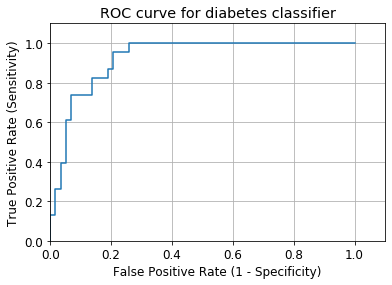

In [41]:
# We can plot  an ROC curve 
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(ptsdy_test, phats[:,1])

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In addition to the ROC curve, I find it useful to review the distribution of hte predicted probabilities from our model, stratifying by the true/observed outcome. This plot lets us visualize the separation of the predicted probabilities. We will specifically use the `phat` variable (as the predicted probability of an event, $P(Y=1) = \hat{p}_1$).

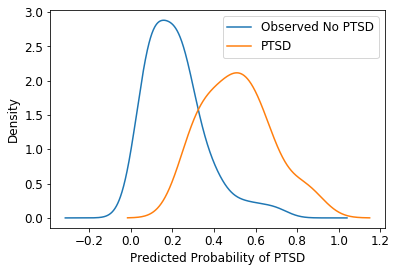

In [53]:
(prediction_df.loc[prediction_df['ObsClass']==0,'phat1']).plot.density()
(prediction_df.loc[prediction_df['ObsClass']==1,'phat1']).plot.density()
plt.legend(labels = ['Observed No PTSD', 'PTSD'])
plt.xlabel("Predicted Probability of PTSD")
plt.ylabel('Density')
plt.show()

In [54]:
# And examining a model summary to look at coefficients and p-values 

In [55]:
np.array(ptsdX_train.columns)[0]

'Age'

In [59]:
results_df = pd.DataFrame({
    'Feature/Covariate':np.array(ptsdX_train.columns),
    'Coefficient':logreg_ptsd.coef_[0]
})

results_df.sort_values('Coefficient')

,Feature/Covariate,Coefficient
13,PTSD_Rx_phenelzine,-3.194857
11,PTSD_Rx_nefazodone,-2.788518
9,PTSD_Rx_clonazepam,-2.450741
14,PTSD_Rx_sertraline,-2.417471
10,PTSD_Rx_midazolam,-2.194086
12,PTSD_Rx_paroxetine,-1.588031
7,IncomeCat_400%+ FPL,-0.137350
4,SocialSupport,-0.037846
3,BeckAnxiety_BL,-0.000694
0,Age,0.007590
